In [1]:
import pandas as od
import numpy as np
import math
import time

from hurst import compute_Hc
import sklearn
from ou_process import*

from Backtesters import *
from UnivarTrendStrategies import *
from timeseriestools import *
import statsmodels.api as sm
from scipy import stats 

from fitter import Fitter, get_common_distributions, get_distributions

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, plot_confusion_matrix

import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('strategy_data_lobniv.csv', index_col= 0, parse_dates = True)
quotes = pd.read_pickle('outfile')


qset = pd.DataFrame(quotes)
qset.columns = ['delivery_time', 'order_book']
qset.set_index('delivery_time', drop = True, inplace = True)
qset['niv'] = data.niv[qset.index[0]: qset.index[-1]]
qset['imb'] = data.imb[qset.index[0]: qset.index[-1]]

# Statistics of the Net Imbalance Volume

<AxesSubplot:title={'center':'NIV sample time series'}, xlabel='delivery_time'>

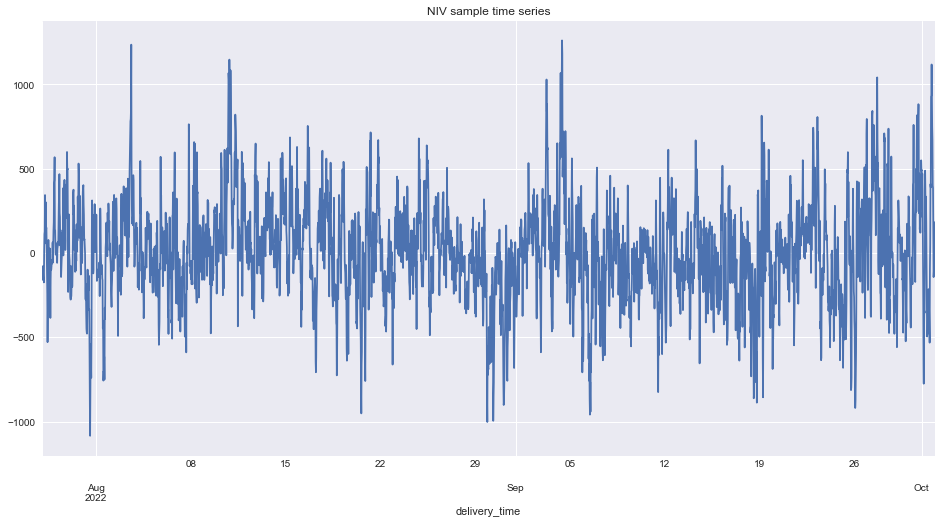

In [3]:
niv_data = qset.niv

niv_data.plot(figsize=(16,8), title = 'NIV sample time series')

<AxesSubplot:title={'center':'Train Set NIV'}, xlabel='delivery_time'>

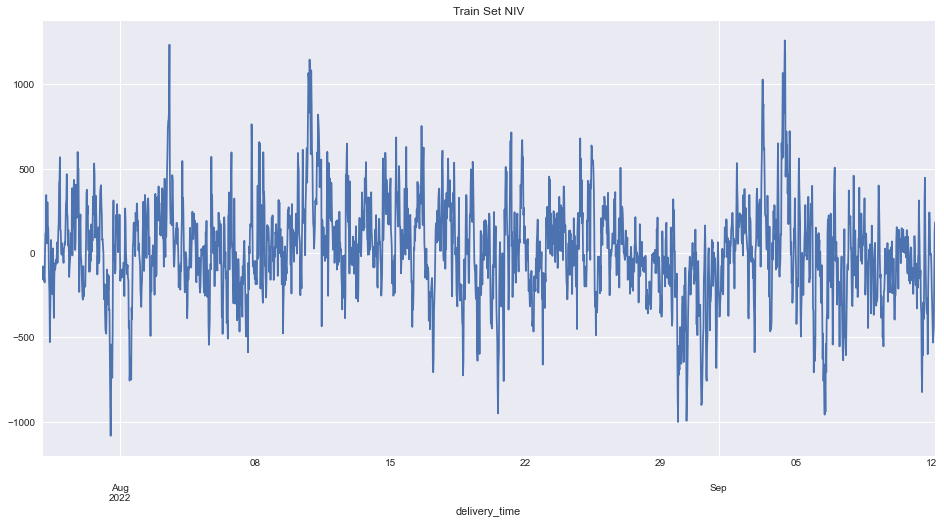

In [4]:
size = math.ceil(0.7 * niv_data.shape[0])

niv_train_set = niv_data[:size]
niv_test_set = niv_data[size:]


niv_train_set.plot(figsize=(16,8), title = 'Train Set NIV')


As it is customary in the literature we run some stationarity test. The ADF test and the KPSS test to see if there are hidden trends.

In [5]:
dickey_fuller_test(niv_train_set)

Augmented Dickey-Fuller test
Test statistic: -12.9189
-----------------------------------
p-value: 3.911573144438548e-24
-----------------------------------
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Hypothesis Testing Results
Null Hyptothesis (H0): True


In [6]:
kpss_test(niv_train_set)

Kwiatkowski-Phillips-Schmidt-Shin test
Test statistic: 0.6519500648577363
-----------------------------------
p-value: 0.017913630467478514
-----------------------------------
num lags: 25
-----------------------------------
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Hypothesis Testing Results
Result: The series is not stationary


We conclude that the time series has some hidden trends that *ignite* some potential heteroskedasticity in the time series according to the KPSS test. 

Driven by the physics of the Net Imbalance Volume we seek if there is evidence of mean reversion of the time series. To do so we estimate parameters of the Ornstein-Uhlenbeck process, and then test if there is evidence for this process

In [7]:
# Estimation of the OU process parameters

params = estimate_OU_params(niv_train_set.values)

training_set_estimate = pd.Series(get_OU_process(T=len(niv_train_set), OU_params=params))
training_set_estimate.index = niv_train_set.index
mae = mean_absolute_error(niv_train_set, training_set_estimate)
rmse = mean_squared_error(niv_train_set, training_set_estimate, squared=False)
accuracy = accuracy_score(np.sign(niv_train_set), np.sign(training_set_estimate))

print('Model Performance')
print('='*80)
print('Mean Absolute Error: {:.2f}'.format(mae))
print('-'*80)
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('-'*80)
print('Direction Accuracy: {:.2f}'.format(accuracy))
print('='*80)

Model Performance
Mean Absolute Error: 292.85
--------------------------------------------------------------------------------
Root Mean Squared Error: 372.98
--------------------------------------------------------------------------------
Direction Accuracy: 0.51


In [9]:
# Test set

testing_set_estimate = pd.Series(get_OU_process(T=len(niv_test_set), OU_params=params))
testing_set_estimate.index = niv_test_set.index
mae = mean_absolute_error(niv_test_set, testing_set_estimate)
rmse = mean_squared_error(niv_test_set, testing_set_estimate, squared=False)
accuracy = accuracy_score(np.sign(niv_test_set), np.sign(testing_set_estimate))

print('Model Performance')
print('='*80)
print('Mean Absolute Error: {:.2f}'.format(mae))
print('-'*80)
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('-'*80)
print('Direction Accuracy: {:.2f}'.format(accuracy))
print('='*80)

Model Performance
Mean Absolute Error: 344.57
--------------------------------------------------------------------------------
Root Mean Squared Error: 428.25
--------------------------------------------------------------------------------
Direction Accuracy: 0.45


With the given sample we conclude that the calibration of the model does not seem to be appropriate for describing the stochastic behaviour of the given time series sample. Nevertheless, that does not prove that the process is non-mean reverting. A final test is using the Hurst Exponent. Recall that The Hurst exponent for a given time series, is a real number $H \in [0,1]$ such that

- if $H \simeq 0.5$ the time series comes from a random walk process.
- if $H > 0.5$ the time series has some persistent behaviour (trending).
- if $H < 0.5$ the time series has some anti-persistent behaviour (mean-reversion).

In [10]:
print('='*80)
print('H of training set {:.4f}'.format(compute_Hc(niv_train_set)[0]))
print('-'*80)
print('H of test set {:.4f}'.format(compute_Hc(niv_test_set)[0]))
print('='*80)

H of training set 0.2491
--------------------------------------------------------------------------------
H of test set 0.2199


According to the Hurst exponent the process is more likely to be mean reverting. This is supported by physical reasons, that means the power grid tries to balance the NIV close to zero, so whenever we are far from that value, the system will act to let the NIV converge to zero. This could be empirically seen by looking at the histogram of the given sample. If that is true, then we would expect to have a mean around a relatively small value when comparing to stochastic fluctuations.

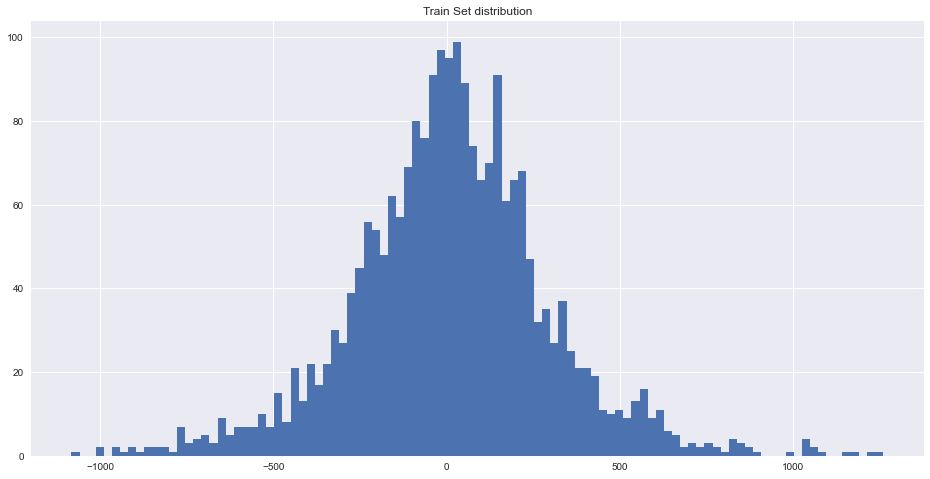

In [11]:
plt.figure(figsize = (16,8))
plt.title('Train Set distribution')
plt.hist(niv_train_set, bins = 100)
plt.show()

In [12]:
print_moments(niv_train_set)

Sample Data Distribution Moments
Sample Mean: 13.04
--------------------------------------------------------------------------------
Sample Standard Deviation: 287.82
--------------------------------------------------------------------------------
Sample skewness: 0.09
--------------------------------------------------------------------------------
Sample Kurtosis: 1.51
--------------------------------------------------------------------------------
Excess of Kurtosis: -1.49


The moments of the sample distribution confirm this fact, the mean of the sample is close to zero (or to a balanced system), the distribution is likely to be *platykurtic*, meaning that the values are more likely to be concentrated into the center of the distribution, the latter is fairly symmetric, having a skewness close to zero. So, there is evidence for mean reversion.

In [13]:
print_moments(niv_test_set)

Sample Data Distribution Moments
Sample Mean: -4.54
--------------------------------------------------------------------------------
Sample Standard Deviation: 316.71
--------------------------------------------------------------------------------
Sample skewness: 0.25
--------------------------------------------------------------------------------
Sample Kurtosis: 0.45
--------------------------------------------------------------------------------
Excess of Kurtosis: -2.55


In this other sample we can see that the hypothesis on the mean is confirmed, the distribution is quite centered, and the excess of kurtosis is even lower than the previous sample. Therefore for this particular population we can conclude that there is likelihood of having a mean reverting process. The OU-process does not seem to capture well from calibration, but perhaps could be useful in Monte Carlo Simulations. 

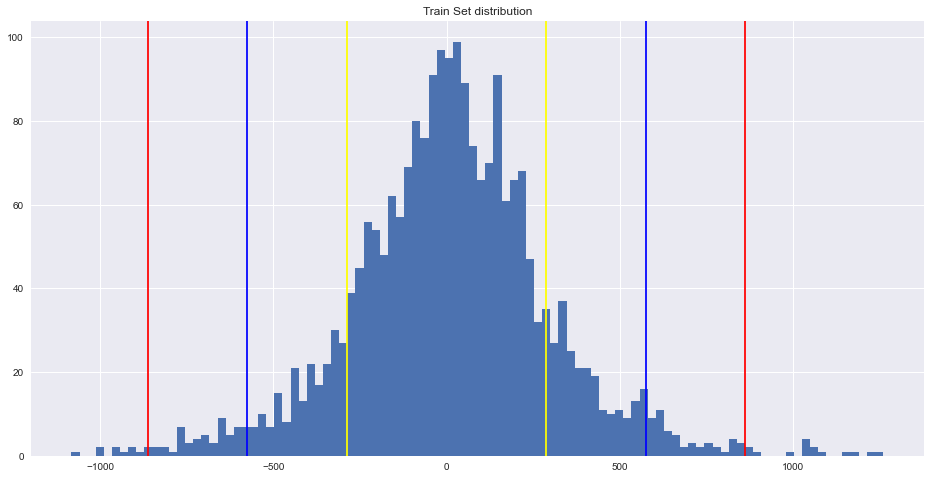

In [14]:
sigma = niv_train_set.std()

plt.figure(figsize = (16,8))
plt.title('Train Set distribution')
plt.hist(niv_train_set, bins = 100)
plt.axvline(sigma, color = 'yellow')
plt.axvline(-sigma, color = 'yellow')
plt.axvline(2*sigma, color = 'b')
plt.axvline(-2*sigma, color = 'b')
plt.axvline(3*sigma, color = 'r')
plt.axvline(-3*sigma, color = 'r')

plt.show()

In [15]:
print('Extreme Events Sample impact')
print('='*80)
print('Density of events outside 3 sigma: {:.3f}'.format(
niv_train_set[niv_train_set > 3*sigma].count() / niv_train_set.shape[0]))
print('-'*80)
print('Density of events outside 3 sigma: {:.3f}'.format(
niv_train_set[niv_train_set < -3*sigma].count() / niv_train_set.shape[0]))
print('='*80)



Extreme Events Sample impact
Density of events outside 3 sigma: 0.007
--------------------------------------------------------------------------------
Density of events outside 3 sigma: 0.005


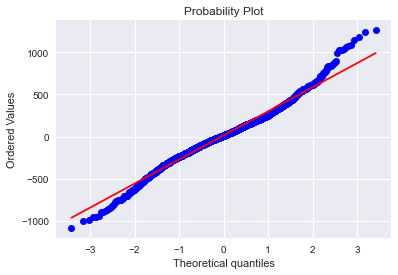

In [16]:
## QQ-Plot for Normality

stats.probplot(niv_train_set, dist = 'norm', plot=plt)
plt.show()

Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 12.24it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,9.015148e-07,1797.815852,-47937.921937,inf,0.013552,0.804713
lognorm,2.275358e-06,1878.327351,-45884.461362,inf,0.046635,0.000125
norm,2.283414e-06,1880.260760,-45884.326697,inf,0.047572,0.000084


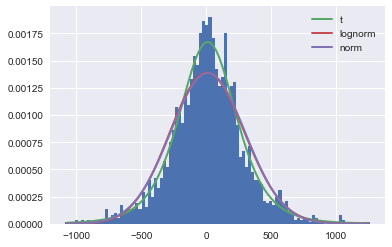

In [17]:
f = Fitter(niv_train_set, distributions = ['norm', 'lognorm', 't'])
f.fit()
f.summary()

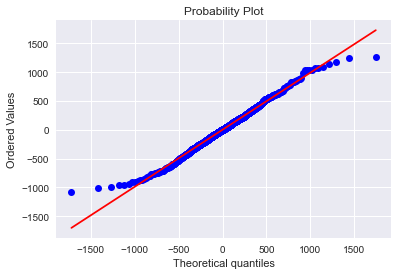

In [18]:
best = f.get_best()['t']

stats.probplot(niv_train_set, dist = stats.t(df = best['df'], loc=best['loc'], scale=best['scale']), plot=plt)
plt.show()

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.000002,1686.79901,-18837.130849,inf,0.018262,0.903414


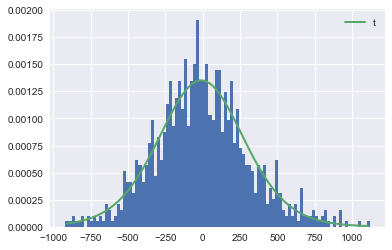

In [19]:
f_test = Fitter(niv_test_set, distributions= 't')
f_test.fit()
f_test.summary()

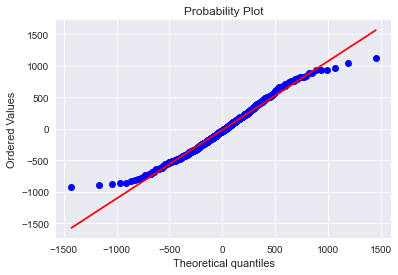

In [20]:
stats.probplot(niv_test_set, dist = stats.t(df = 4.97, loc=12.43, scale=226.80), plot=plt)
plt.show()

There is evidence that the niv data follows a t-distribution. Then we can calibrate the quantiles accordingly

In [21]:
class NIVDistribution():
    
    '''Retrieves t-distributions and compute quantiles for a given alpha'''
    
    def __init__(self, data: pd.Series):
        self.data = data
        
        self.fit_t_distribution()
        self.get_params()
        
        
    def fit_t_distribution(self):
        data = self.data.copy()
        f = Fitter(data=data, distributions='t')
    
    def get_params(self) -> dict:
        best = f.get_best()['t']
        self.best = best
        
    def compute_cdf(self, value: float) -> float:
        
        best = self.best
        df = best['df']
        loc = best['loc']
        scale = best['scale']
        
        return round(stats.t.cdf(value, df=df, loc=loc, scale=scale),2)
        
    
    def get_complete_cdf(self) -> pd.DataFrame:
        
        data = self.data.copy()
        
        probas = []
        
        for value in data:
            probas.append(self.compute_cdf(value=value))
            
        result = data.to_frame('niv')
        result['proba'] = probas
        
        return result    
    
    
    
    def quantile(self, alpha:float) -> float:
        
        results = self.get_complete_cdf()
        
        q = results.query(f'proba == {alpha}')
        
        return q.niv.mean()
        
        

## NIV Lags prediction 


We evaluate standard metrics on the prediction given by the lags

In [22]:
def print_model_performance(data: pd.Series, k:int) -> float:
    
    df = data.copy()
    mae = mean_absolute_error(df[k:], df.shift(k).dropna())
    rmse = mean_squared_error(df[k:], df.shift(k).dropna(), squared=False)
    accuracy = accuracy_score(np.sign(df[k:]), np.sign(df.shift(k).dropna()))
    
    print(f'Lag {k} foreast performance')
    print('='*80)
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('-'*80)
    print('Mean Standard Error: {:.2f}'.format(rmse))
    print('-'*80)
    print('Direction accuracy: {:.2f}'.format(accuracy))

## LAG 2 Evaluation

In [23]:
print_model_performance(niv_train_set, k = 2)

Lag 2 foreast performance
Mean Absolute Error: 182.21
--------------------------------------------------------------------------------
Mean Standard Error: 237.87
--------------------------------------------------------------------------------
Direction accuracy: 0.72


In [24]:
print_model_performance(niv_test_set, k = 2)

Lag 2 foreast performance
Mean Absolute Error: 230.20
--------------------------------------------------------------------------------
Mean Standard Error: 296.98
--------------------------------------------------------------------------------
Direction accuracy: 0.68


## LAG 3 Evaluation

In [25]:
print_model_performance(niv_train_set, k = 3)

Lag 3 foreast performance
Mean Absolute Error: 219.44
--------------------------------------------------------------------------------
Mean Standard Error: 282.55
--------------------------------------------------------------------------------
Direction accuracy: 0.67


In [26]:
print_model_performance(niv_test_set, k = 3)

Lag 3 foreast performance
Mean Absolute Error: 269.97
--------------------------------------------------------------------------------
Mean Standard Error: 348.87
--------------------------------------------------------------------------------
Direction accuracy: 0.63


## LAG 4 Evaluation

In [27]:
print_model_performance(niv_train_set, k = 4)

Lag 4 foreast performance
Mean Absolute Error: 238.91
--------------------------------------------------------------------------------
Mean Standard Error: 305.81
--------------------------------------------------------------------------------
Direction accuracy: 0.64


In [28]:
print_model_performance(niv_test_set, k = 4)

Lag 4 foreast performance
Mean Absolute Error: 294.06
--------------------------------------------------------------------------------
Mean Standard Error: 380.85
--------------------------------------------------------------------------------
Direction accuracy: 0.62


For this particular sample the best predictor, that is stable between the train and test split is the LAG 2 model. Indeed 

**LAG 2**

- mae discrepancy = 48 MW
- rmse discrepancy = 59,11 MW
- Accuracy discrepancy = 0.02

**LAG 3**

- mae discrepancy = 50,53 MW
- rmse discrepancy = 66,32 MW
- Accuracy discrepancy = 0.01

**LAG 4**

- mae discrepancy = 55,15 MW
- rmse discrepancy = 75,04 MW
- Accuracy discrepancy = 0.02


## Performance Test for LAG 2 on specific distribution portions.



In [29]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

distrib = NIVDistribution(niv_train_set)

dist_qs = []

for q in quantiles:
    dist_qs.append(round(distrib.quantile(alpha=q),2))

In [30]:
# Performance Central Quantile

print_model_performance(niv_test_set[(niv_test_set >=dist_qs[1]) & (niv_test_set <= dist_qs[4])], k=2)

Lag 2 foreast performance
Mean Absolute Error: 152.84
--------------------------------------------------------------------------------
Mean Standard Error: 195.95
--------------------------------------------------------------------------------
Direction accuracy: 0.61


In [31]:
q1 = distrib.quantile(0.45)
q2 = distrib.quantile(0.50)

print_model_performance(niv_test_set[(niv_test_set >=q1) & (niv_test_set <= q2)], k=2)

Lag 2 foreast performance
Mean Absolute Error: 7.49
--------------------------------------------------------------------------------
Mean Standard Error: 9.25
--------------------------------------------------------------------------------
Direction accuracy: 0.50


The Central Quantile is the one that performs worse in predicting the NIV direction.

## Trades Analysis. 

Investigating typical statistical features of trades per settlement period.

- Basic Statistics of Trades.
- Proving disproving popular believs "trades converge to imbalance prices"

In [36]:
trades = pd.read_csv('trades.csv') #, index_col = 'delivery_time', parse_dates=True)
trades

,time,delivery_time,price,volume
0,2022-09-30 21:02:34.801,2022-09-30 23:30:00+00:00,79.89,1.0
1,2022-09-30 21:02:34.801,2022-09-30 23:30:00+00:00,79.99,3.0
2,2022-09-30 21:40:24.918,2022-09-30 23:30:00+00:00,40.50,1.0
3,2022-09-30 21:40:51.165,2022-09-30 23:30:00+00:00,31.50,0.2
4,2022-09-30 21:41:10.660,2022-09-30 23:30:00+00:00,31.00,2.6
...,...,...,...,...
1115689,2022-09-14 23:36:45.360,2022-09-15 00:00:00+00:00,259.99,0.2
1115690,2022-09-14 23:36:45.360,2022-09-15 00:00:00+00:00,260.00,10.0
1115691,2022-09-14 23:36:48.462,2022-09-15 00:00:00+00:00,261.00,10.0
1115692,2022-09-14 23:37:45.993,2022-09-15 00:00:00+00:00,272.98,0.4


In [37]:
def trading_stats(data: pd.DataFrame) -> list:
    
    # Averages
    
    avg_traded_price = data.price.mean()
    stdev_traded_price = data.price.std()
    avg_traded_volume = data.volume.mean()
    
    # Quantities
    
    traded_volume = data.volume.sum()
    n_trades = len(data)
    settlement_price = data.price[-1]
    
    return (avg_traded_price, stdev_traded_price, avg_traded_volume, traded_volume, n_trades, settlement_price)     
    

In [38]:
trades['timestamp'] = trades.index
trades.set_index('delivery_time', inplace=True, drop = True)
trades = trades[['timestamp', 'price', 'volume']]

trades['niv'] = qset.niv
trades['imb_price'] = qset.imb

# For studying the convergence of trades to imbalance prices.

trades['convergence'] = abs(trades.imb_price.sub(trades.price))
trades["time_to_maturity"] = (pd.to_datetime(trades.index, utc=True)-pd.to_datetime(trades["timestamp"], utc=True)).dt.seconds / 60


trades.sort_values(by = 'delivery_time', inplace=True)


tradestats = []
tradesnimb = []

for frame in trades.groupby('delivery_time'):
    
    tradestats.append(trading_stats(frame[1]))
    tradesnimb.append((frame[1].timestamp, frame[1].price, frame[1].imb_price, frame[1].convergence))
    
tradestats = pd.DataFrame(tradestats)
tradestats.columns = ['avg_price', 'volatility', 'avg_volume', 'traded_volume', 'n_trades', 'settlement']
tradestats.index = trades.index.unique()

tradestats['niv'] = qset.niv
tradestats['imb_price'] = qset.imb    
tradestats['convergence'] = abs(tradestats.imb_price.sub(tradestats.avg_price))



array([<AxesSubplot:xlabel='delivery_time'>,
       <AxesSubplot:xlabel='delivery_time'>,
       <AxesSubplot:xlabel='delivery_time'>], dtype=object)

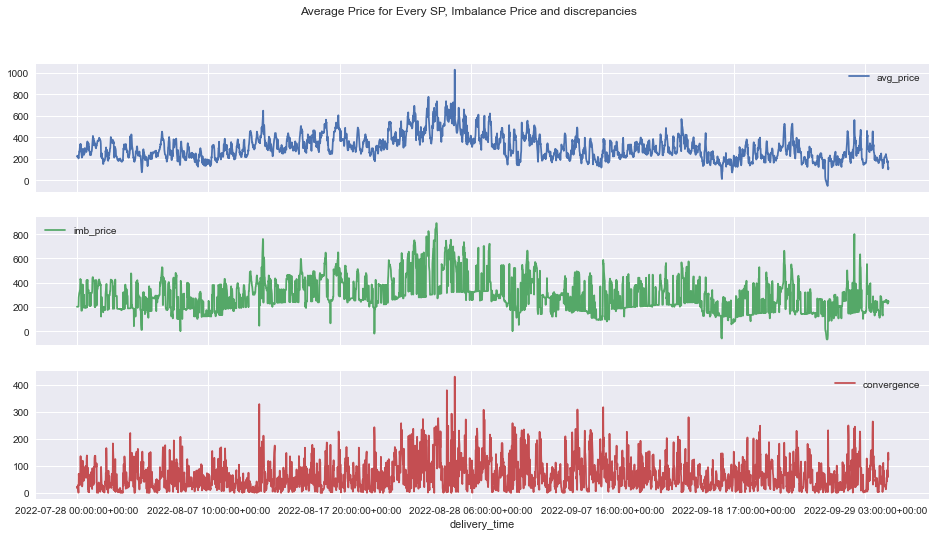

In [39]:
tradestats[['avg_price', 'imb_price', 'convergence']].plot(figsize=(16,8), title = 'Average Price for Every SP, Imbalance Price and discrepancies', subplots=True)

In [40]:
tradestats[['avg_price', 'imb_price', 'convergence']].describe()

,avg_price,imb_price,convergence
count,3090.000000,3090.000000,3090.000000
mean,304.731338,297.944313,64.595511
std,115.578978,141.343016,54.295826
min,-53.363020,-68.730000,0.025974
25%,221.054526,189.095000,24.287464
50%,288.255880,275.680000,50.815874
75%,370.256214,381.252500,89.843868
max,1028.587942,890.000000,429.587942


In [41]:
print('Percentage of Trades converging to imbalance prices {:.2f} %'.format(100* tradestats.query('convergence < 5').shape[0] / tradestats.shape[0]))

Percentage of Trades converging to imbalance prices 5.70 %


In this case the convergence is computed by seeing if for some small $\epsilon$ the distance

$$ |P_i - IP_i | < \epsilon, \forall i \in \{1, 2, ..., T \} $$

Where $P_i$ is the traded price and $IP_i$ is the imbalance price of the relevant settlement period.


We conclude that on average there is no significant evidence of convergence of trades to imbalance prices. We carry the analysis on every trade level

In [44]:
print('Percentage of Trades converging to imbalance prices {:.2f} %'.format(100* trades.query('convergence < 5').shape[0] / trades.shape[0]))

Percentage of Trades converging to imbalance prices 5.74 %


<AxesSubplot:xlabel='delivery_time'>

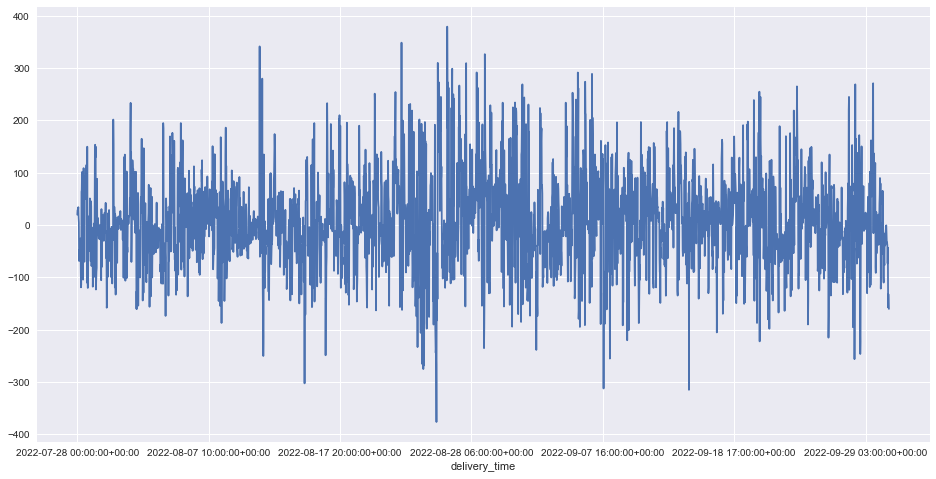

In [45]:
# The difference time series is quite noisy

(tradestats.settlement - tradestats.imb_price).plot(figsize=(16,8))

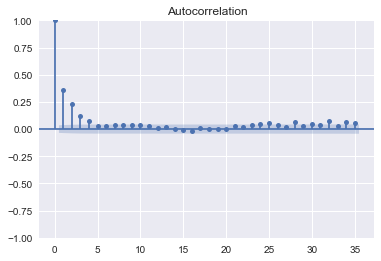

In [47]:
# Shows significant autocorrelation.

acf = plot_acf((tradestats.settlement - tradestats.imb_price))

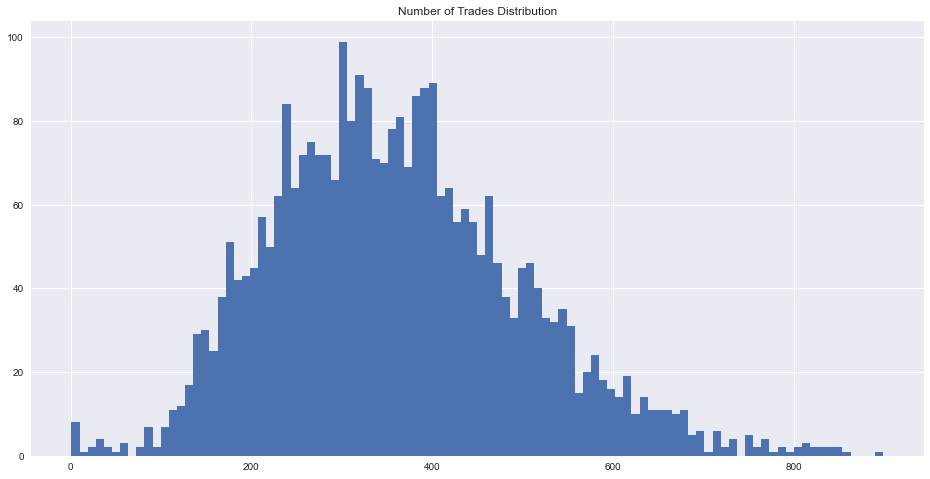

In [48]:
plt.figure(figsize=(16,8))
plt.title('Number of Trades Distribution')
plt.hist(tradestats.n_trades, bins=100)
plt.show()

# Limit Order Book Analysis: level=1, Market Orders


We carry an analysis of the Limit Order Book at level 1, that is the level of Market Orders. The dataset is a monitoring of how the very first layer of the LOB changes over time.

In [49]:
def midprice(bid:float, ask:float) -> float:
    return 0.5 * (bid + ask)

def microprice(bid_size:float, bid:float, ask:float, ask_size:float) -> float:
    imb = bid_size / (bid_size + ask_size)
    return ask*imb + bid*(1-imb)

def order_book_imbalance(bid_size, ask_size):
    return (bid_size - ask_size) / (bid_size + ask_size)        
    

In [50]:
info_qset = qset.copy()
info_qset['expiry'] = info_qset.index - pd.Timedelta(minutes = 15)

info_qset.set_index('expiry', drop=True, inplace=True)

midprice_ts = []
microprice_ts = []
lobimb_ts = []

deliveries = info_qset.index

for delivery_time in deliveries:
    
    order_book = info_qset.loc[str(delivery_time)].order_book.dropna()
    
    for layer in range(len(order_book)):
        
        midpri = midprice(order_book.bid.iloc[layer], order_book.ask.iloc[layer])
        mpri = microprice(order_book.bid_size.iloc[layer], order_book.bid.iloc[layer],
                          order_book.ask.iloc[layer], order_book.ask_size.iloc[layer])
        lomb = order_book_imbalance(order_book.bid_size.iloc[layer],
                                    order_book.ask_size.iloc[layer])
        
        idx = order_book.index[layer]
        
        midprice_ts.append((delivery_time, idx, midpri))
        microprice_ts.append((delivery_time, idx, mpri))
        lobimb_ts.append((delivery_time, idx, lomb))
        
        
midprice_df = pd.DataFrame(midprice_ts)
microprice_df = pd.DataFrame(microprice_ts)
lobimb_df = pd.DataFrame(lobimb_ts)

columns = ['delivery_time', 'timestamp', 'price']
midprice_df.columns = columns
microprice_df.columns = columns
lobimb_df.columns = columns

midprice_df.set_index('delivery_time', inplace=True, drop=True)
microprice_df.set_index('delivery_time', inplace=True, drop=True)
lobimb_df.set_index('delivery_time', inplace=True, drop=True)

microstructure = pd.concat([midprice_df.price,
                            microprice_df.price,
                            lobimb_df.price], axis=1)

microstructure.columns = ['midprice', 'microprice', 'lob_imb']

microstructure['timestamp'] = microprice_df.timestamp 

#microstructure.set_index('delivery_time', drop=True, inplace=True)

microstructure = microstructure[['timestamp', 'midprice', 'microprice', 'lob_imb']]


microstructure['niv'] = info_qset.niv
microstructure['imb_price'] = info_qset.imb


In [51]:

microstructure['time_to_delivery'] = (pd.to_datetime(microstructure.index, utc=True)-pd.to_datetime(microstructure["timestamp"], utc=True)).dt.seconds / 60
microstructure['pctchange'] = microstructure.microprice.pct_change() #Tracks changes in time

In [52]:
def structure_viz(delivery_time: pd.Timestamp, columns: list, resample: str = False) -> plt.plot:
    
    if resample:
        
        microstructure.loc[str(delivery_time)].set_index('timestamp')[columns].resample(resample).mean().plot(figsize=(16,8), subplots=True)
    
    else:
        
        microstructure.loc[str(delivery_time)].set_index('timestamp')[columns].plot(figsize=(16,8), subplots=True)

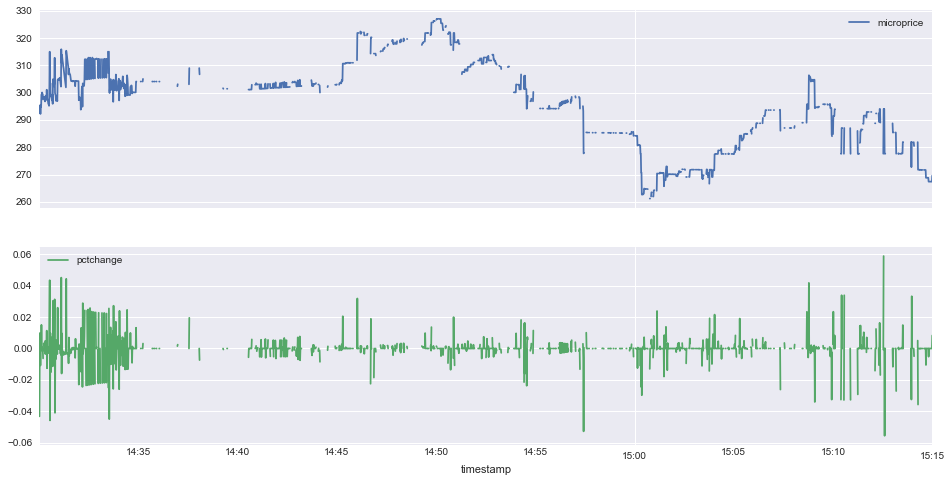

In [53]:
structure_viz('2022-07-28 15:15:00+00:00', columns=['microprice', 'pctchange'], resample='1s')

In [54]:
def localize_df(delivery_time: pd.Timestamp, columns: list, resample: str = False) -> pd.DataFrame:
    if resample:
        
        return microstructure.loc[str(delivery_time)].set_index('timestamp')[columns].resample(resample).mean()
    
    else:
        
        return microstructure.loc[str(delivery_time)].set_index('timestamp')[columns]
    

In [56]:
def cutoff(returns: pd.Series) -> float:
    
    # cutoff function Algoritmic and HFT by Alvaro Cartea and Sebastian Jaimugal
    # Chapter 3, section 3.2
    
    r_min = returns.min()
    fraction = returns / r_min
    T = len(returns)
    nlog = np.log(fraction)
    nlog[nlog == np.inf] = np.NaN
    nlog[nlog == -np.inf] = np.NaN
    nlog.dropna(inplace = True)
    
    return round(1 + T * (nlog.sum())**(-1),4)
    

<AxesSubplot:ylabel='Frequency'>

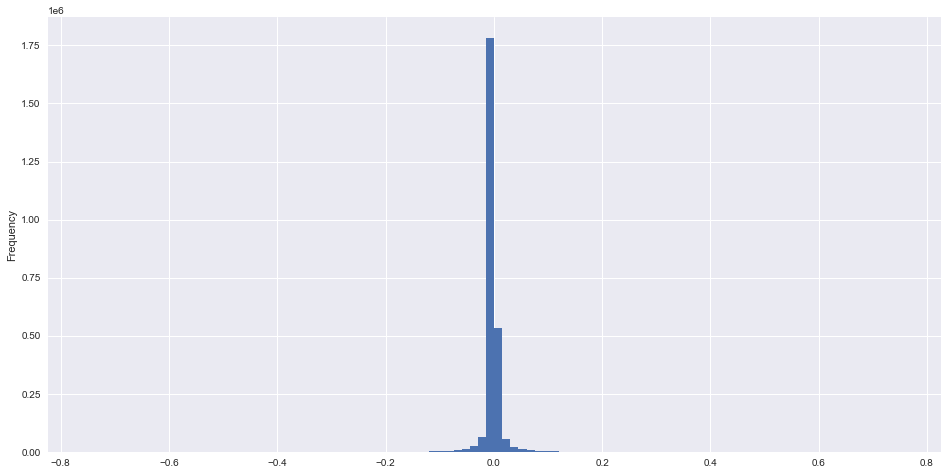

In [57]:
mic = microstructure.copy()
mic.pctchange[mic.pctchange == np.inf] = np.NaN
mic.pctchange[mic.pctchange == -np.inf] = np.NaN
mic_clean = mic.query(f'pctchange >= {-cutoff(mic.pctchange)} & pctchange <= {cutoff(mic.pctchange)} & time_to_delivery < 50')


mic_clean.pctchange.plot(figsize=(16,8), kind='hist', bins = 100)

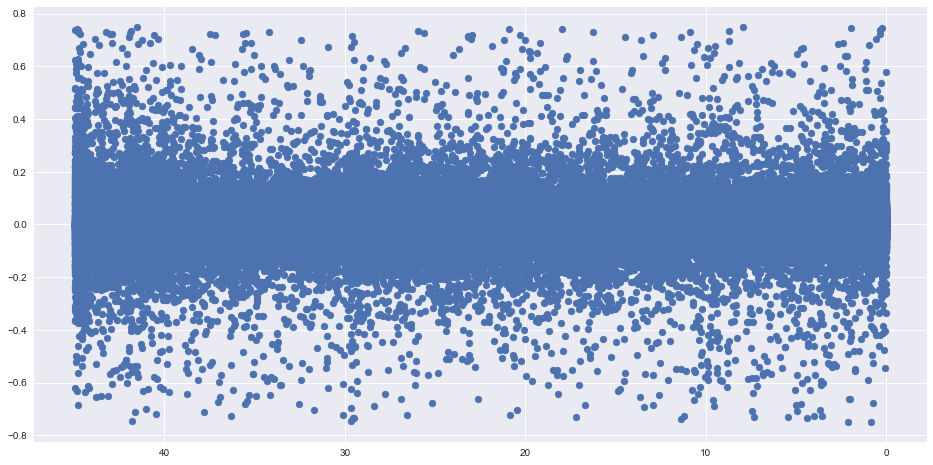

In [58]:
resampled = mic_clean.set_index('timestamp', drop = True).resample('1s').mean().dropna()

plt.figure(figsize=(16,8))
plt.scatter(x = resampled['time_to_delivery'], y = resampled['pctchange'])
plt.gca().invert_xaxis()
plt.show()

We try to explore the impact of upregs and downregs on the *informed* order book by looking at the microprice.

In [59]:
resampled_upreg = resampled.query('niv > 0')
resampled_downreg = resampled.query('niv < 0')

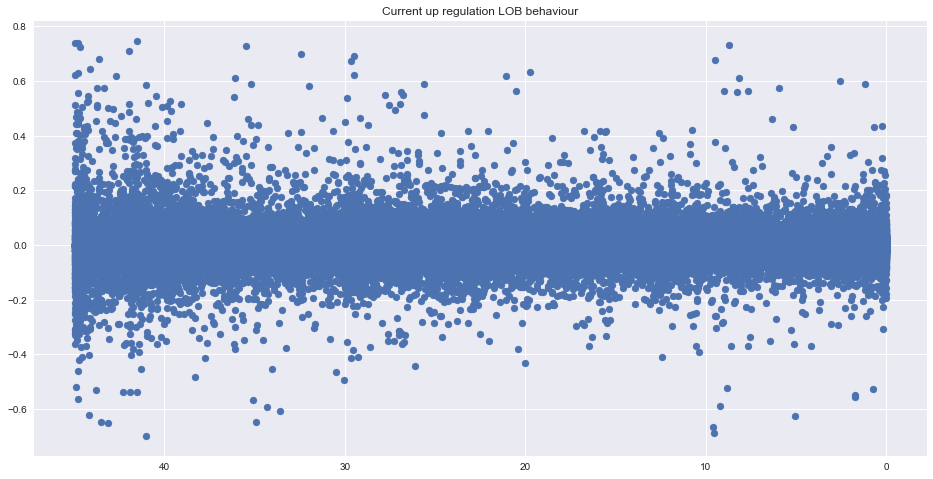

In [60]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_upreg['time_to_delivery'], y = resampled_upreg['pctchange'])
plt.title('Current up regulation LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

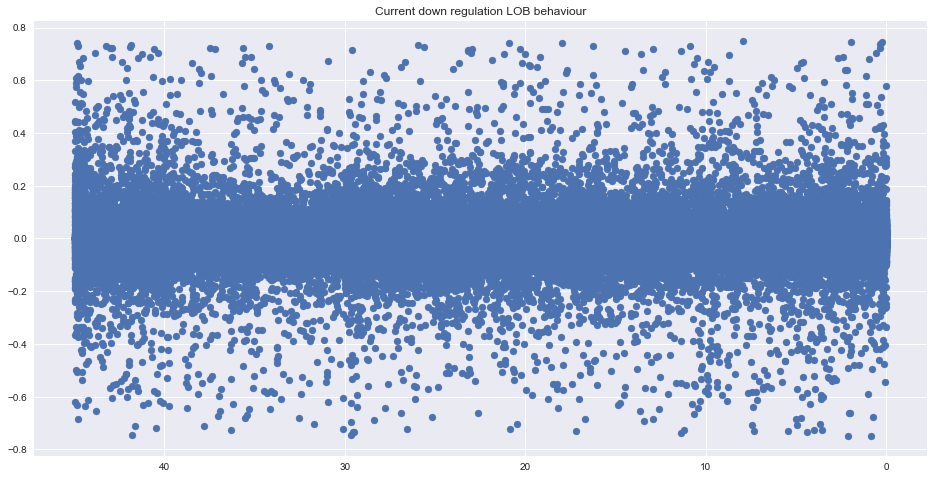

In [61]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_downreg['time_to_delivery'], y = resampled_downreg['pctchange'])
plt.title('Current down regulation LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

It seems that the market is more certain on the direction when looking at upregs rather than downregs. We carry the same analysis on the various estimated portions of the NIV

In [62]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

distrib = NIVDistribution(pd.Series(microstructure.niv.unique()))

dist_qs = []

for q in quantiles:
    dist_qs.append(round(distrib.quantile(alpha=q),2))
    
    
qs = {'0.05': dist_qs[0], '0.25': dist_qs[1], '0.5': dist_qs[2], '0.75': dist_qs[3], '0.95': dist_qs[4]}


resampled_q0525 = resampled.query(f'niv >= {qs["0.05"]} & niv <= {qs["0.25"]}')
resampled_q2550 = resampled.query(f'niv > {qs["0.25"]} & niv <= {qs["0.5"]}')
resampled_q5075 = resampled.query(f'niv > {qs["0.5"]} & niv <= {qs["0.75"]}')
resampled_q7595 = resampled.query(f'niv > {qs["0.75"]} & niv <= {qs["0.95"]}')

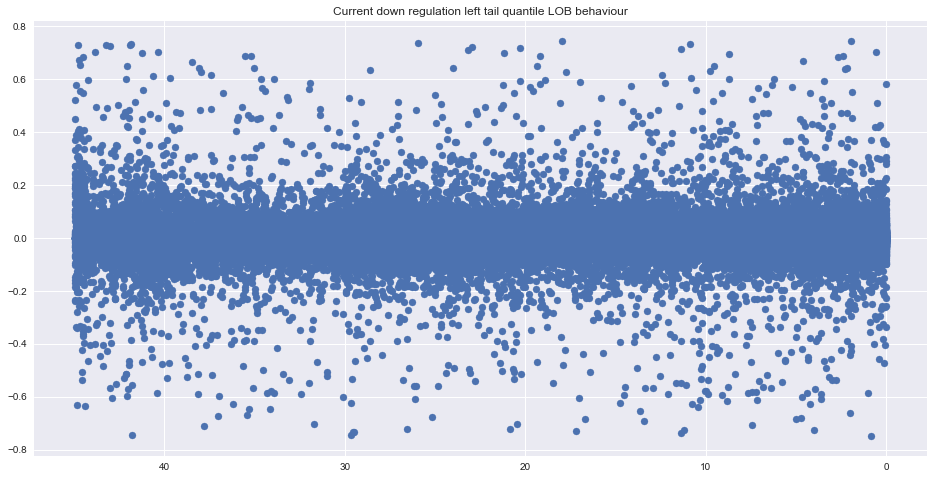

In [63]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_q0525['time_to_delivery'], y = resampled_q0525['pctchange'])
plt.title('Current down regulation left tail quantile LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

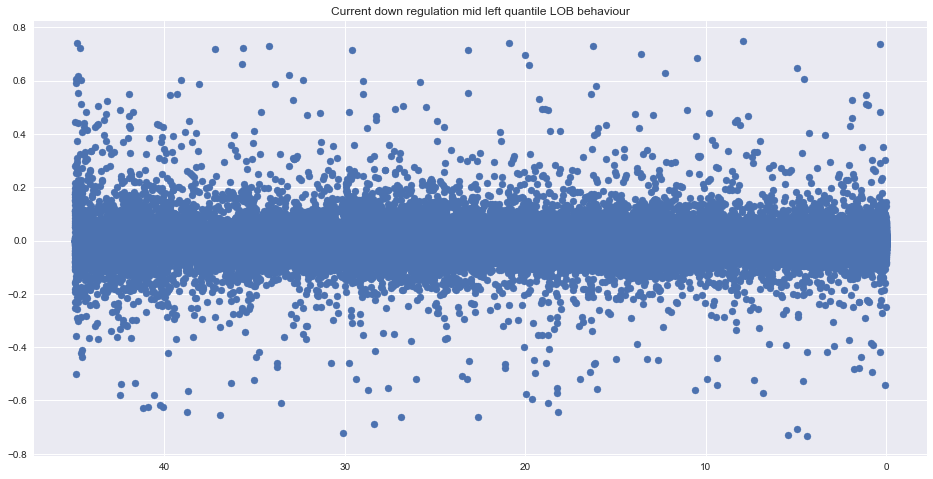

In [64]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_q2550['time_to_delivery'], y = resampled_q2550['pctchange'])
plt.title('Current down regulation mid left quantile LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

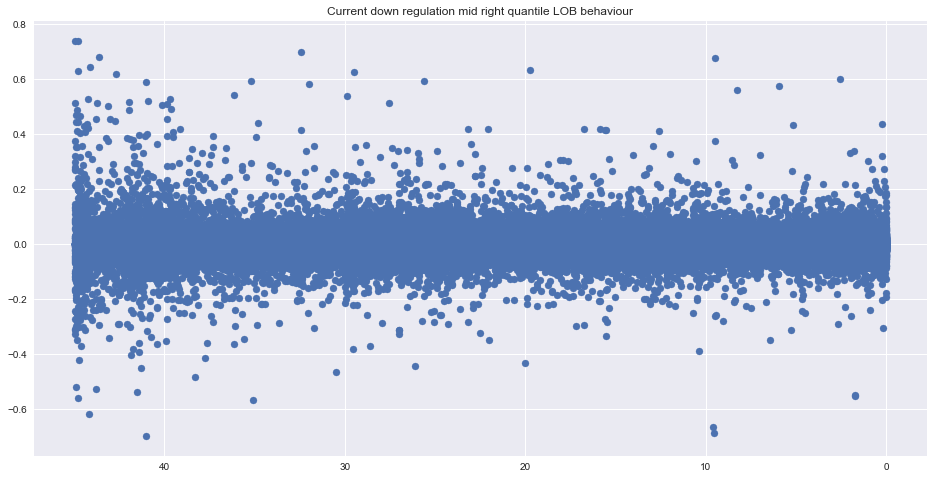

In [65]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_q5075['time_to_delivery'], y = resampled_q5075['pctchange'])
plt.title('Current down regulation mid right quantile LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

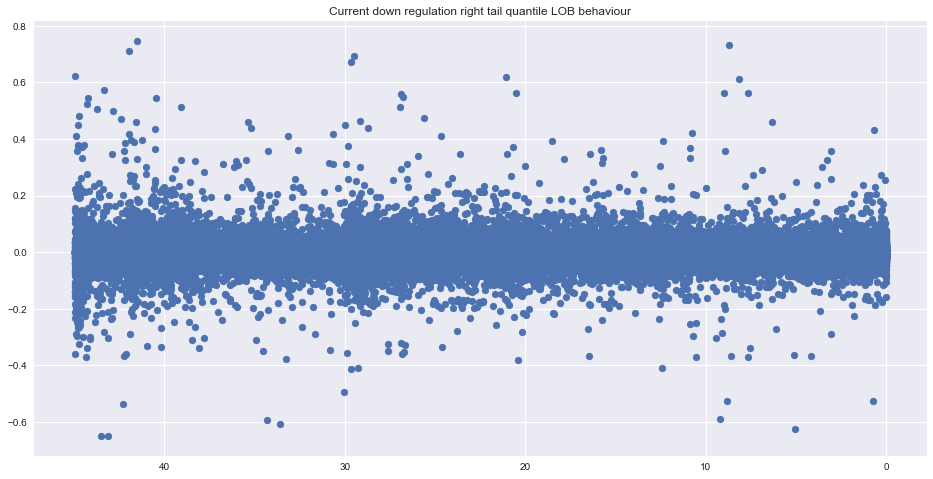

In [66]:
plt.figure(figsize=(16,8))
plt.scatter(x = resampled_q7595['time_to_delivery'], y = resampled_q7595['pctchange'])
plt.title('Current down regulation right tail quantile LOB behaviour')
plt.gca().invert_xaxis()
plt.show()

Below we measure the impact of how the NIV direction is a correct predictor of the Order Book dynamics at level 1.

In [67]:
price_delta = []

deliveries = mic_clean.index.unique()

for delivery_time in deliveries:
    
    dataset = mic_clean.loc[str(delivery_time)]
    first_price = dataset.microprice[0]
    last_price = dataset.microprice[-1]
    difference = -(first_price - last_price)
    lob_init_imb = dataset.lob_imb[0]
    lob_last_imb = dataset.lob_imb[-1]
    avg_pct_change = dataset.pctchange.mean()
    niv = dataset.niv[0]
    imb_price = dataset.imb_price[0]
    
    price_delta.append((delivery_time, difference, last_price, lob_init_imb, lob_last_imb, avg_pct_change, niv, imb_price))
    
    
df = pd.DataFrame(data=price_delta)

df.columns = ['delivery_time', 'mkt_move', 'last_price', 'lob_imb_start', 'lob_imb_end', 'avg_change', 'niv', 'imb_price']
df.set_index('delivery_time', drop=True, inplace=True)

In [68]:
df_q0525 = df.query(f'niv >= {qs["0.05"]} & niv <= {qs["0.25"]}')
df_q2550 = df.query(f'niv > {qs["0.25"]} & niv <= {qs["0.5"]}')
df_q5075 = df.query(f'niv > {qs["0.5"]} & niv <= {qs["0.75"]}')
df_q7595 = df.query(f'niv > {qs["0.75"]} + 100 & niv <= {qs["0.95"]}')

In [69]:
def get_accuracy(df: pd.DataFrame) -> np.ndarray:
    
    y_pred = np.sign(df.niv)
    y_true = np.sign(df.mkt_move)
    
    corrects = (y_pred == y_true).sum()
    N = df.shape[0]
    
    print('='*80)
    print('Correctly Classified {:.2f}'.format(corrects/N))
    print('-'*80)
    print('Misclassified {:.2f}'.format(1 - corrects/N))
    print('='*80)

In [70]:
get_accuracy(df_q0525)

Correctly Classified 0.79
--------------------------------------------------------------------------------
Misclassified 0.21


In [71]:
get_accuracy(df_q2550)

Correctly Classified 0.62
--------------------------------------------------------------------------------
Misclassified 0.38


In [72]:
get_accuracy(df_q5075)

Correctly Classified 0.59
--------------------------------------------------------------------------------
Misclassified 0.41


In [73]:
get_accuracy(df_q7595)

Correctly Classified 0.85
--------------------------------------------------------------------------------
Misclassified 0.15
